# **IMPORT LIBRARY YANG DIBUTUHKAN**



In [396]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from datetime import datetime as dt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# **LOAD/GATHERING DATA**

In [397]:
df = pd.read_csv("Bakery sales.csv")
df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


# **PREPROCESSING DATA**

## **PENYESUAIAN TIPE DATA**

In [399]:
df['date'] = pd.to_datetime(df['date'])

In [400]:
df['time'] = pd.to_datetime(df['time'])

In [401]:
df['unit_price'] = df['unit_price'].str.replace(' €', '')
df['unit_price'] = df['unit_price'].str.replace(',', '.')
df['unit_price'] = df['unit_price'].astype(float)

## **PENYESUAIAN NAMA KOLOM**

In [402]:
df=df.rename(columns={"Quantity":"quantity"})

## **CLEANING DATA**

In [403]:
df = df.drop(df.columns[0], axis=1)
df

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,2023-12-25 08:38:00,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,2023-12-25 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,2023-12-25 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,2023-12-25 09:14:00,150041.0,PAIN,1.0,1.15
4,2021-01-02,2023-12-25 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20
...,...,...,...,...,...,...
234000,2022-09-30,2023-12-25 18:52:00,288911.0,COUPE,1.0,0.15
234001,2022-09-30,2023-12-25 18:52:00,288911.0,BOULE 200G,1.0,1.20
234002,2022-09-30,2023-12-25 18:52:00,288911.0,COUPE,2.0,0.15
234003,2022-09-30,2023-12-25 18:55:00,288912.0,TRADITIONAL BAGUETTE,1.0,1.30


### **MISSING VALUE**

In [404]:
df.isnull().sum()

date             0
time             0
ticket_number    0
article          0
quantity         0
unit_price       0
dtype: int64

### **ASSESSING DATA**

In [405]:
df.describe()

,ticket_number,quantity,unit_price
count,234005.000000,234005.000000,234005.000000
mean,219201.258738,1.538377,1.662195
std,40053.223896,1.289603,1.722720
min,150040.000000,-200.000000,0.000000
25%,184754.000000,1.000000,1.100000
50%,218807.000000,1.000000,1.200000
75%,253927.000000,2.000000,1.500000
max,288913.000000,200.000000,60.000000


Terdapat nilai yang tidak masuk akal. Dimana ada quantity dan unit_price yang nilainya minus.

In [406]:
df[(df['unit_price'] <= 0) | (df['quantity'] <= 0)].count()

date             1326
time             1326
ticket_number    1326
article          1326
quantity         1326
unit_price       1326
dtype: int64

In [407]:
df = df[(df['unit_price'] > 0) & (df['quantity'] > 0)]
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,2023-12-25 08:38:00,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,2023-12-25 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,2023-12-25 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,2023-12-25 09:14:00,150041.0,PAIN,1.0,1.15
4,2021-01-02,2023-12-25 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


In [408]:
df.describe()

,ticket_number,quantity,unit_price
count,232679.000000,232679.000000,232679.000000
mean,219173.584346,1.556462,1.659715
std,40067.194649,1.198053,1.718190
min,150040.000000,1.000000,0.070000
25%,184728.000000,1.000000,1.100000
50%,218677.000000,1.000000,1.200000
75%,253975.000000,2.000000,1.500000
max,288913.000000,200.000000,60.000000


Disini kami menambahkan 12 kolom baru, yaitu total dan hour. Kolom total akan menampung hasil perkalian quantity dengan unit_price. Sedangkan kolom hour akan berisi nilai jam yang ada di kolom time. Kemudian kolom time juga akan dihapus.

In [409]:
df['total'] = df['quantity'] * df['unit_price']
df['hour'] = df['time'].dt.hour
df["M"] = df["date"].dt.month
df

<ipython-input-409-26fbb82d385c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-409-26fbb82d385c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-409-26fbb82d385c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,time,ticket_number,article,quantity,unit_price,total,hour,M
0,2021-01-02,2023-12-25 08:38:00,150040.0,BAGUETTE,1.0,0.90,0.90,8,1
1,2021-01-02,2023-12-25 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,3.60,8,1
2,2021-01-02,2023-12-25 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2.40,9,1
3,2021-01-02,2023-12-25 09:14:00,150041.0,PAIN,1.0,1.15,1.15,9,1
4,2021-01-02,2023-12-25 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,6.00,9,1
...,...,...,...,...,...,...,...,...,...
234000,2022-09-30,2023-12-25 18:52:00,288911.0,COUPE,1.0,0.15,0.15,18,9
234001,2022-09-30,2023-12-25 18:52:00,288911.0,BOULE 200G,1.0,1.20,1.20,18,9
234002,2022-09-30,2023-12-25 18:52:00,288911.0,COUPE,2.0,0.15,0.30,18,9
234003,2022-09-30,2023-12-25 18:55:00,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,1.30,18,9


In [410]:
df = df.drop(columns="time")
df.head()

,date,ticket_number,article,quantity,unit_price,total,hour,M
0,2021-01-02,150040.0,BAGUETTE,1.0,0.90,0.90,8,1
1,2021-01-02,150040.0,PAIN AU CHOCOLAT,3.0,1.20,3.60,8,1
2,2021-01-02,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2.40,9,1
3,2021-01-02,150041.0,PAIN,1.0,1.15,1.15,9,1
4,2021-01-02,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,6.00,9,1


# **EXPLORATORY DATA ANALYSIS (EDA)**

## **PRODUK TERLARIS**

In [411]:
articles_top = df.groupby('article').agg({'quantity':'sum'}).sort_values(by = 'quantity', ascending = False).reset_index().head(10)
articles_top

,article,quantity
0,TRADITIONAL BAGUETTE,118093.0
1,CROISSANT,29822.0
2,PAIN AU CHOCOLAT,25367.0
3,COUPE,23601.0
4,BANETTE,22870.0
5,BAGUETTE,22156.0
6,CEREAL BAGUETTE,7478.0
7,SPECIAL BREAD,5488.0
8,FORMULE SANDWICH,5285.0
9,TARTELETTE,5051.0


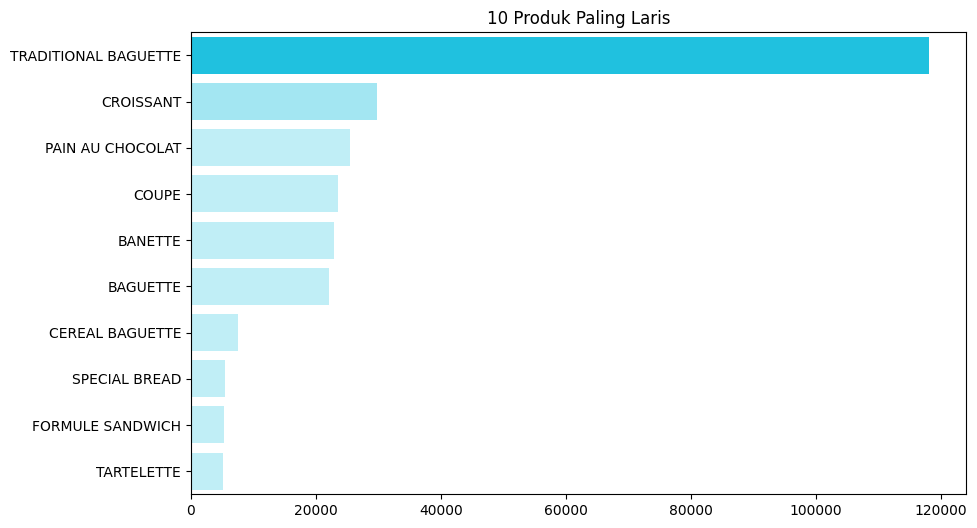

In [412]:
fig, ax = plt.subplots(figsize=(10,6))
colors = ["#00D7FF", "#96EFFF", "#b7f4ff", "#b7f4ff", "#b7f4ff", "#b7f4ff", "#b7f4ff", "#b7f4ff", "#b7f4ff", "#b7f4ff"]
sns.barplot(x="quantity", y="article", data=articles_top, palette=colors)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title("10 Produk Paling Laris", fontsize=12)
ax.tick_params(axis ='y', labelsize=10)

## **PRODUK PALING TIDAK LARIS**

In [413]:
articles_bottom = df.groupby('article').agg({'quantity':'sum'}).sort_values(by = 'quantity', ascending = True).reset_index().head(10)
articles_bottom

,article,quantity
0,"PLATPREPARE6,00",1.0
1,CAKE,1.0
2,REDUCTION SUCREES 24,1.0
3,PLAT 6.50E,1.0
4,SACHET DE VIENNOISERIE,1.0
5,DOUCEUR D HIVER,1.0
6,TROIS CHOCOLAT,1.0
7,PAIN NOIR,1.0
8,GALETTE 8 PERS,2.0
9,BUCHE 8PERS,2.0


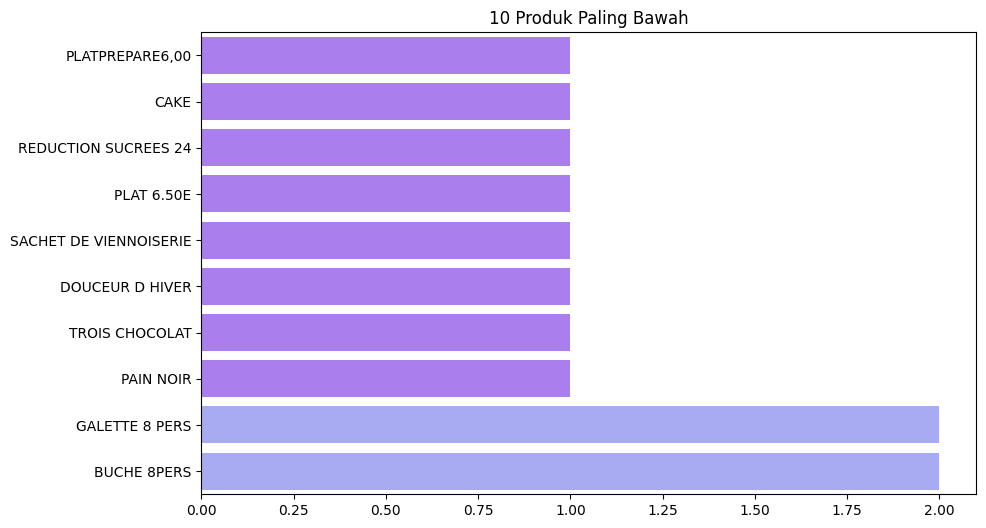

In [414]:
fig, ax = plt.subplots(figsize=(10,6))
colors = ["#A66CFF", "#A66CFF", "#A66CFF", "#A66CFF", "#A66CFF", "#A66CFF", "#A66CFF", "#A66CFF", "#9C9EFE", "#9C9EFE"]
sns.barplot(x="quantity", y="article", data=articles_bottom, palette=colors)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title("10 Produk Paling Bawah", fontsize=12)
ax.tick_params(axis ='y', labelsize=10)

## **TOTAL ROTI TERJUAL PER JAM**

In [415]:
hours_sales = df.groupby('hour').agg({'quantity':'sum'}).reset_index()
hours_sales

,hour,quantity
0,7,13526.0
1,8,50659.0
2,9,57874.0
3,10,64820.0
4,11,69552.0
5,12,52580.0
6,13,8808.0
7,14,259.0
8,15,140.0
9,16,12462.0


In [416]:
fig = px.pie(hours_sales,names="hour",values=hours_sales['quantity'],hole=0.6,title="Total Roti Terjual Per Jam")
fig.update_traces(textposition='inside',textinfo='percent+label',sort=False)
fig.update_layout(title_x=0.5)

fig.show()

## **TOTAL ROTI TERJUAL PER HARI**

In [417]:
daily = df.groupby(pd.to_datetime(df['date']).dt.strftime('%A'))['quantity'].sum().sort_values(ascending=False)
print("Jumlah order per hari adalah: \n", daily)

Jumlah order per hari adalah: 
 date
Sunday       83694.0
Saturday     62240.0
Friday       48434.0
Monday       48008.0
Thursday     45207.0
Tuesday      42799.0
Wednesday    31774.0
Name: quantity, dtype: float64


In [418]:
fig = px.pie(daily, daily.index,values=daily.values,hole=0.6,title="Total Roti Terjual Per Hari")
fig.update_traces(textposition='outside',textinfo='percent+label',sort=False)
fig.update_layout(title_x=0.5)
fig.show()

## **TOTAL ROTI TERJUAL PER BULAN**

In [419]:
monthly = df.groupby("M", as_index=False).agg(total_sales_volume=("quantity","sum"))
monthly

,M,total_sales_volume
0,1,18535.0
1,2,23539.0
2,3,25786.0
3,4,31829.0
4,5,37448.0
5,6,32363.0
6,7,57766.0
7,8,67033.0
8,9,28759.0
9,10,15044.0


In [420]:
fig = px.pie(monthly,names="M",values="total_sales_volume",hole=0.6,title="Total Roti Terjual Per Bulan")
fig.update_traces(textposition='outside',textinfo='percent+label',sort=False)
fig.update_layout(title_x=0.5)
fig.show()

## **TOTAL PEMASUKAN HARIAN**

In [421]:
daily_sales = df.groupby('date').agg({'total':'sum'}).reset_index()

In [422]:
daily_sales.head()


,date,total
0,2021-01-02,987.85
1,2021-01-03,1015.20
2,2021-01-04,461.90
3,2021-01-05,526.10
4,2021-01-07,544.00


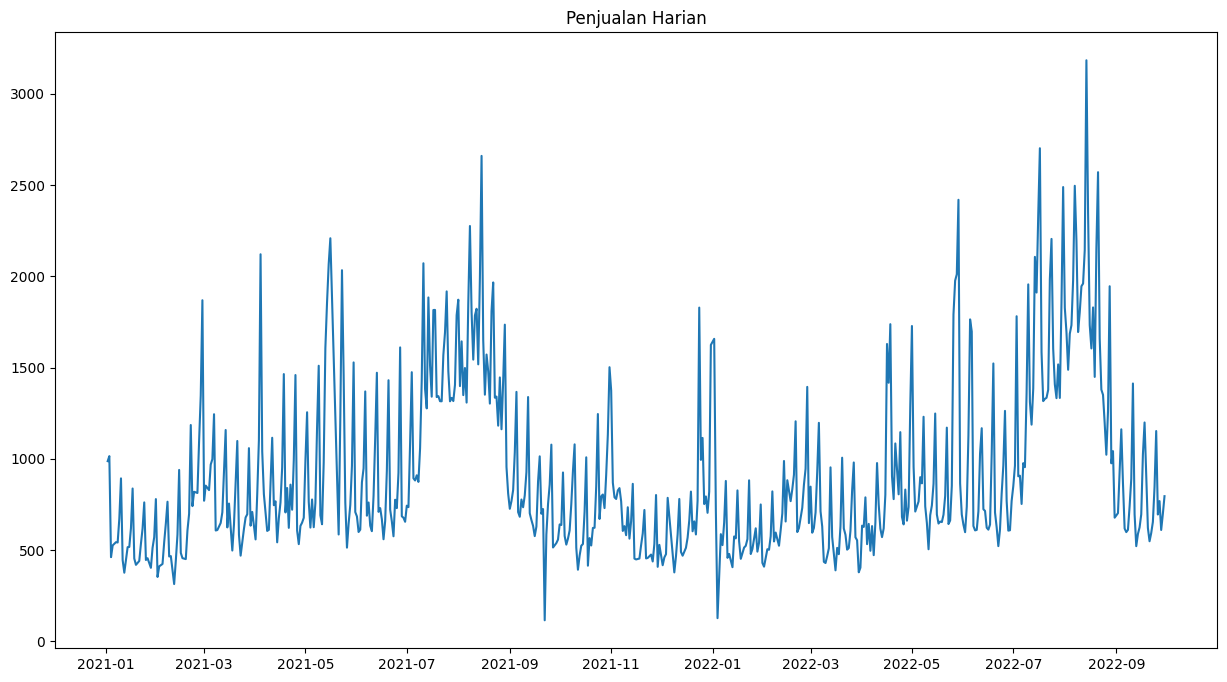

In [423]:
#creating a daily sales plot
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(daily_sales['date'], daily_sales['total'])
ax.set_title('Penjualan Harian')
plt.show()

## **TOTAL PEMASUKAN MINGGUAN**

In [424]:
daily_sales.set_index('date', inplace = True)


In [425]:
weekly_sales = daily_sales.resample('W').sum()


In [426]:
weekly_sales

,total
date,
2021-01-03,2003.05
2021-01-10,3640.45
2021-01-17,3315.72
2021-01-24,3231.40
2021-01-31,3169.30
...,...
2022-09-04,5497.25
2022-09-11,5740.85
2022-09-18,5352.70


Text(0.5, 1.0, 'Penjualan Mingguan')

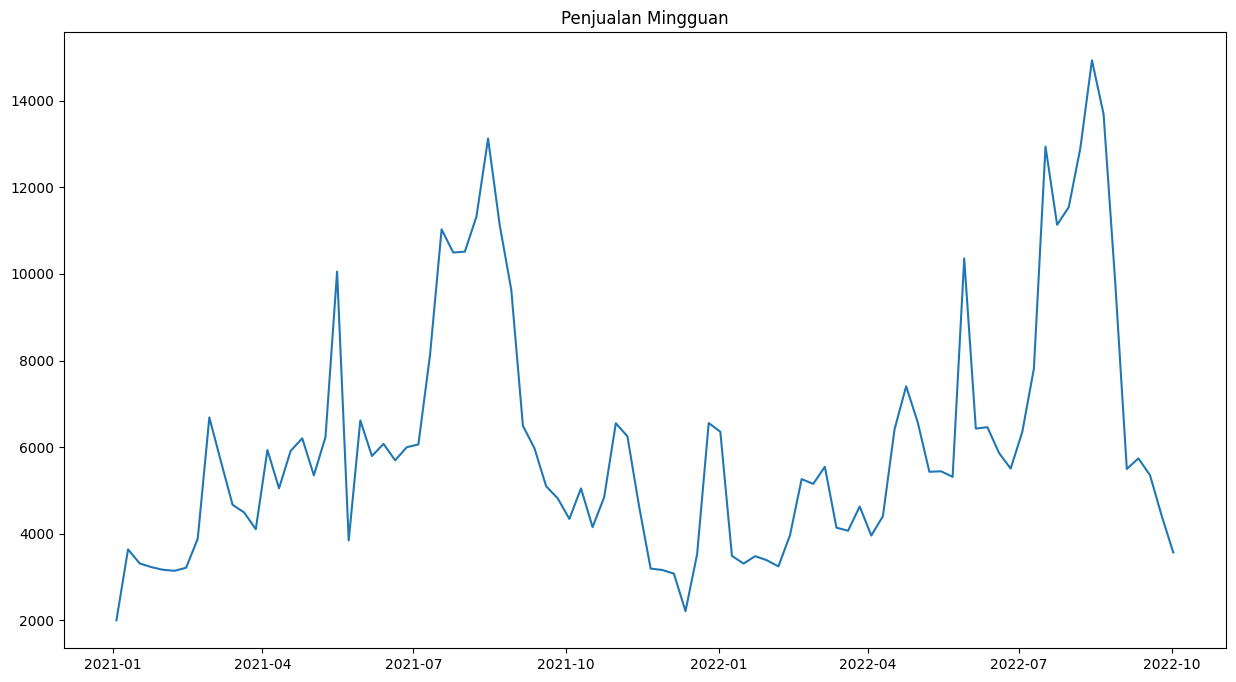

In [427]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(weekly_sales.index, weekly_sales['total'])
ax.set_title('Penjualan Mingguan')

# **FORECASTING MENGGUNAKAN ARIMA**

## **PEMBAGIAN DATA TRAINING DAN TESTING**

In [428]:
train = daily_sales[:int(0.7*len(daily_sales))]
test = daily_sales[int(0.7*len(daily_sales)):]

## **PEMBENTUKAN MODEL MENGGUNAKAN ALGORITMA ARIMA**

In [429]:
ar = ARIMA(test, order=(15,0,15)).fit()
ar_train = ar.fittedvalues

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

## **PLOT HASIL PEMODELAN**

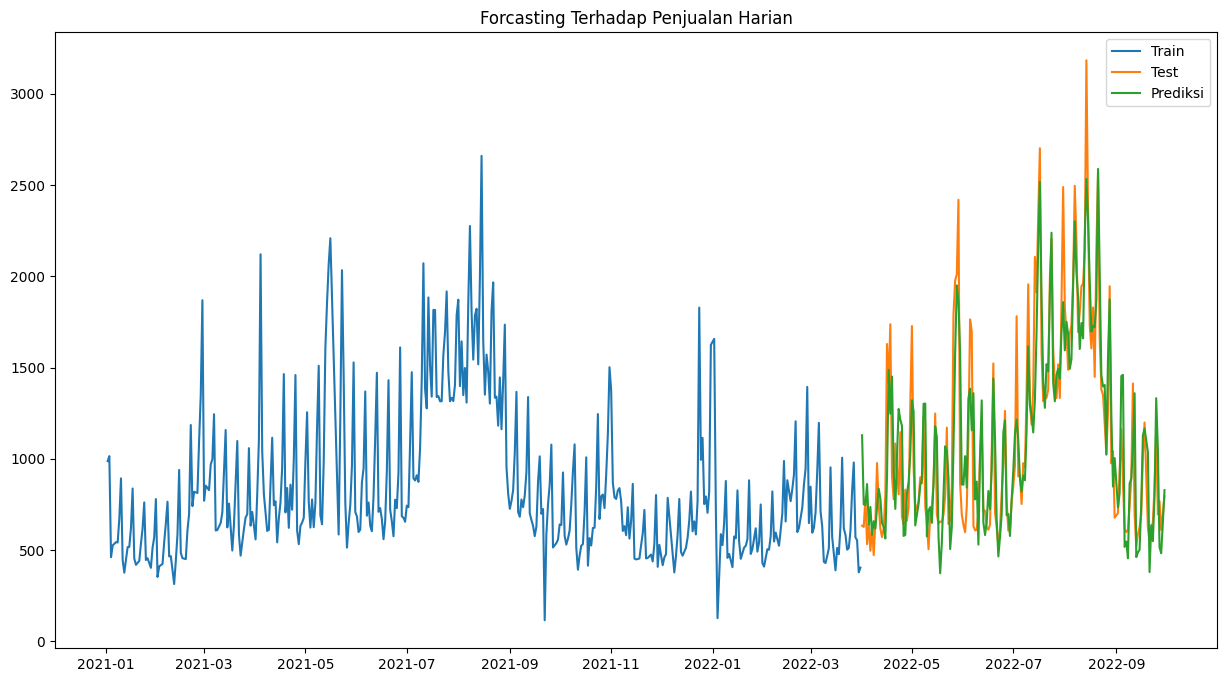

In [430]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(ar_train, label="Prediksi")
ax.set_title('Forcasting Terhadap Penjualan Harian')
ax.legend()


## **MENGHITUNG NILAI MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)**

In [431]:
print("Nilai MAPE : ", mean_absolute_percentage_error(test, ar_train))

Nilai MAPE :  0.1964899386526088


In [432]:
df.to_csv('df.csv')